In [1]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import os

# Get the current working directory (optional)
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

# Define the new directory path
new_directory = "I:/loca2/gen_use"  # Replace with your desired path

# Change the directory
try:
    os.chdir(new_directory)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_directory}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Current directory: C:\Users\Ben
Successfully changed directory to: I:\loca2\gen_use


In [ ]:
import dask

def calculate_percentile(file_path, percentile=95, threshold=1):
    """
    Calculates the specified percentile of daily precip (pr)
    at each grid point in a NetCDF file, using dask for lazy evaluation.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 99).
        threshold (float, optional): Threshold for pr * 86400 (default: 0.01).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the calculated percentile of pr for each grid point.
                            Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Enable dask chunks
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds['pr'] = ds['pr'] * 86400
    # Apply the threshold condition
    valid_data = ds['pr'].where(ds['pr'] >= threshold)

    # Calculate the percentile along the time dimension
    percentile_values = valid_data.quantile(percentile / 100, dim='time')

    return percentile_values.compute()  # Compute the result

file_path = "pr.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_99 = calculate_percentile(file_path, percentile=95, threshold=1)

if percentile_99 is not None:
    print(percentile_99)

    # Save to NetCDF (optional)
    try:
        percentile_99.to_netcdf("VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '95th Percentile (mm)'})

        plt.title("95th Percentile Precip, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2015-2044_VWD_ACCESS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2045-2074_VWD_ACCESS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def calculate_percentile(file_path, percentile=95, threshold=1):
    """
    Calculates the specified percentile of daily precip (pr)
    at each grid point in a NetCDF file, using dask for lazy evaluation.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 99).
        threshold (float, optional): Threshold for pr * 86400 (default: 0.01).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the calculated percentile of pr for each grid point.
                            Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Enable dask chunks
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds['pr'] = ds['pr'] * 86400
    # Apply the threshold condition
    valid_data = ds['pr'].where(ds['pr'] >= threshold)

    # Calculate the percentile along the time dimension
    percentile_values = valid_data.quantile(percentile / 100, dim='time')

    return percentile_values.compute()  # Compute the result

file_path = "pr.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_99 = calculate_percentile(file_path, percentile=95, threshold=1)

if percentile_99 is not None:
    print(percentile_99)

    # Save to NetCDF (optional)
    try:
        percentile_99.to_netcdf("VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '95th Percentile (mm)'})

        plt.title("95th Percentile Precip, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2015-2044_VWD_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2045-2074_VWD_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def calculate_percentile(file_path, percentile=95, threshold=1):
    """
    Calculates the specified percentile of daily precip (pr)
    at each grid point in a NetCDF file, using dask for lazy evaluation.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 99).
        threshold (float, optional): Threshold for pr * 86400 (default: 0.01).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the calculated percentile of pr for each grid point.
                            Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Enable dask chunks
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds['pr'] = ds['pr'] * 86400
    # Apply the threshold condition
    valid_data = ds['pr'].where(ds['pr'] >= threshold)

    # Calculate the percentile along the time dimension
    percentile_values = valid_data.quantile(percentile / 100, dim='time')

    return percentile_values.compute()  # Compute the result

file_path = "pr.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_99 = calculate_percentile(file_path, percentile=95, threshold=1)

if percentile_99 is not None:
    print(percentile_99)

    # Save to NetCDF (optional)
    try:
        percentile_99.to_netcdf("VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '95th Percentile (mm)'})

        plt.title("95th Percentile Precip, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2015-2044_VWD_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2045-2074_VWD_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def calculate_percentile(file_path, percentile=95, threshold=1):
    """
    Calculates the specified percentile of daily precip (pr)
    at each grid point in a NetCDF file, using dask for lazy evaluation.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 99).
        threshold (float, optional): Threshold for pr * 86400 (default: 0.01).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the calculated percentile of pr for each grid point.
                            Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Enable dask chunks
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds['pr'] = ds['pr'] * 86400
    # Apply the threshold condition
    valid_data = ds['pr'].where(ds['pr'] >= threshold)

    # Calculate the percentile along the time dimension
    percentile_values = valid_data.quantile(percentile / 100, dim='time')

    return percentile_values.compute()  # Compute the result

file_path = "pr.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_99 = calculate_percentile(file_path, percentile=95, threshold=1)

if percentile_99 is not None:
    print(percentile_99)

    # Save to NetCDF (optional)
    try:
        percentile_99.to_netcdf("VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '95th Percentile (mm)'})

        plt.title("95th Percentile Precip, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2015-2044_VWD_MIROC.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2045-2074_VWD_MIROC.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def calculate_percentile(file_path, percentile=95, threshold=1):
    """
    Calculates the specified percentile of daily precip (pr)
    at each grid point in a NetCDF file, using dask for lazy evaluation.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 99).
        threshold (float, optional): Threshold for pr * 86400 (default: 0.01).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the calculated percentile of pr for each grid point.
                            Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Enable dask chunks
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds['pr'] = ds['pr'] * 86400
    # Apply the threshold condition
    valid_data = ds['pr'].where(ds['pr'] >= threshold)

    # Calculate the percentile along the time dimension
    percentile_values = valid_data.quantile(percentile / 100, dim='time')

    return percentile_values.compute()  # Compute the result

file_path = "pr.MPI-ESM1-2-HR.historical.r3i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_99 = calculate_percentile(file_path, percentile=95, threshold=1)

if percentile_99 is not None:
    print(percentile_99)

    # Save to NetCDF (optional)
    try:
        percentile_99.to_netcdf("VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '95th Percentile (mm)'})

        plt.title("95th Percentile Precip, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2015-2044_VWD_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days where daily precip exceeds the 99th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily pr (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "pr_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    ds_data['pr'] = ds_data['pr'] * 86400
    
    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_data['pr'] > ds_percentiles['pr']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_FLOOD_95_exceedance_counts_2045-2074_VWD_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_FLOOD_01A*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "pr"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_FLOOD_01A_95exceedance_GENUSE-AVE_2015-2044.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_FLOOD_01B*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "pr"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_FLOOD_01B_95exceedance_GENUSE-AVE_2045-2074.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
def map_99(netcdf_file, variable_name="pr_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=180, cbar_kwargs={'label': 'Count'})

        plt.title("GenUse-Average - Mean Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_01A_95exceedance_GENUSE-AVE_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def map_99(netcdf_file, variable_name="pr_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=180, cbar_kwargs={'label': 'Count'})

        plt.title("GenUse-Average - Mean Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_01B_95exceedance_GENUSE-AVE_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=180, cbar_kwargs={'label': 'Count'})

        plt.title("AccessCM2 - Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_95_exceedance_counts_2015-2044_VWD.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
def map_99(netcdf_file, variable_name="pr", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=180, cbar_kwargs={'label': 'Count'})

        plt.title("AccessCM2 - Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_95_exceedance_counts_2045-2074_VWD.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import itertools
from scipy.stats import linregress
import seaborn as sns
# Load the NetCDF files
filenames = ["VCP_FLOOD_01A_95exceedance_GENUSE-AVE_2015-2044.nc", 
             "VCP_FLOOD_95_exceedance_counts_2015-2044_VWD.nc"]
data_arrays = []

for filename in filenames:
    try:
        ds = xr.open_dataset(filename)
        data_var_name = list(ds.data_vars)[0]
        data_arrays.append(ds[data_var_name].values)
        ds.close()
    except FileNotFoundError:
        print(f"File {filename} not found.")
        exit()
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        exit()

# Flatten the 2D arrays for scatter plots and PCA
flattened_arrays = [arr.flatten() for arr in data_arrays]

# Scatter plots with R-squared
combinations = list(itertools.combinations(range(len(flattened_arrays)), 2))
for i, j in combinations:
    x = flattened_arrays[i]
    y = flattened_arrays[j]

    # Remove NaN values before calculating R-squared
    nan_mask = np.logical_or(np.isnan(x), np.isnan(y))
    x_clean = x[~nan_mask]
    y_clean = y[~nan_mask]

    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    r_squared = r_value**2

    # Option 2: Define a specific range (if you know your data's bounds)


    plt.figure()
    plt.scatter(x, y, s=1)
    plt.xlabel(filenames[i])
    plt.ylabel(filenames[j])
    plt.plot([0, 300], [0, 300], 'y--')
    plt.title(f"Scatter plot: {filenames[i]} vs {filenames[j]} (R² = {r_squared:.3f})")  # Display R-squared
    plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import itertools
from scipy.stats import linregress
import seaborn as sns
# Load the NetCDF files
filenames = ["VCP_FLOOD_01B_95exceedance_GENUSE-AVE_2045-2074.nc", 
             "VCP_FLOOD_95_exceedance_counts_2045-2074_VWD.nc"]
data_arrays = []

for filename in filenames:
    try:
        ds = xr.open_dataset(filename)
        data_var_name = list(ds.data_vars)[0]
        data_arrays.append(ds[data_var_name].values)
        ds.close()
    except FileNotFoundError:
        print(f"File {filename} not found.")
        exit()
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        exit()

# Flatten the 2D arrays for scatter plots and PCA
flattened_arrays = [arr.flatten() for arr in data_arrays]

# Scatter plots with R-squared
combinations = list(itertools.combinations(range(len(flattened_arrays)), 2))
for i, j in combinations:
    x = flattened_arrays[i]
    y = flattened_arrays[j]

    # Remove NaN values before calculating R-squared
    nan_mask = np.logical_or(np.isnan(x), np.isnan(y))
    x_clean = x[~nan_mask]
    y_clean = y[~nan_mask]

    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    r_squared = r_value**2

    # Option 2: Define a specific range (if you know your data's bounds)


    plt.figure()
    plt.scatter(x, y, s=1)
    plt.xlabel(filenames[i])
    plt.ylabel(filenames[j])
    plt.plot([0, 300], [0, 300], 'y--')
    plt.title(f"Scatter plot: {filenames[i]} vs {filenames[j]} (R² = {r_squared:.3f})")  # Display R-squared
    plt.show()

In [ ]:
    # --- Example Usage ---
    precipitation_file = "pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc" # Replace with your actual file path
    file_95 = "VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc"                      # Replace with your actual file path

In [13]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'total_extreme_precipitation_dask.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: total_extreme_precipitation_dask.nc
Results successfully saved to: total_extreme_precipitation_dask.nc


In [19]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Defaulting to 'pr95' for clarity, overridden in main if needed
    pr_chunks={'time': 'auto'},
    percentile_chunks={}
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        print(f"Opening precipitation file: {pr_file_path} with chunks: {pr_chunks}")
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        print(f"Opening percentile file: {percentile_file_path} with chunks: {percentile_chunks}")
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important to handle the NaNs correctly. This is a lazy Dask operation.
        total_extreme_pr = daily_pr.sum(dim='time', skipna=True)

        # Assign a name and attributes for clarity in output
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        original_pr_units = ds_pr[pr_variable_name].attrs.get('units', 'unknown')
        total_extreme_pr.attrs['description'] = (
            f"Sum of daily precipitation (original units: {original_pr_units}, scaled by 86400) "
            f"on days when daily precipitation exceeded the {percentile_variable_name} "
            f"from {percentile_file_path}."
        )
        # Determine units after scaling (assuming original is kg m-2 s-1 or similar rate)
        if original_pr_units.lower() in ['kg m-2 s-1', 'kg/m2/s']:
            total_extreme_pr.attrs['units'] = 'mm' # Assuming 1 kg m-2 s-1 * 86400 s/day = mm/day
        else:
            total_extreme_pr.attrs['units'] = f"scaled {original_pr_units}"


        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client for monitoring computations.
    # Highly recommended for larger datasets to understand performance.
    # from dask.distributed import Client
    # client = Client() # Creates a local cluster
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # Your code uses 'pr' for the percentile variable name in the main block.
    # The function's default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    precip_chunks_config = {'time': 'auto'} # Chunk along time, let Dask decide size
    # For percentile file, if it's 2D (lat,lon), chunking might be {'lat': 'auto', 'lon': 'auto'}
    # or {} if small enough to be loaded or handled as few chunks.
    percentile_chunks_config = {'lat': 'auto', 'lon': 'auto'} # Or simply {} or {'time': -1} if time dim shouldn't be chunked

    # --- Calculation ---
    print("Starting Dask calculation for extreme precipitation sum...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure

        # --- Optional: Save the result to a new NetCDF file ---
        # The filename from your snippet was 'total_precipitation.nc'.
        # If calculating extreme sum, 'total_extreme_precipitation.nc' might be more descriptive.
        output_filepath = 'total_extreme_precipitation_dask_output.nc' # Changed for clarity
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # This is where Dask will perform the actual computation and write to disk.
            # For very large outputs, ensure you have disk space.
            # You can specify encoding for compression in to_netcdf for efficiency.
            # e.g., encoding = {total_extreme_pr.name: {"zlib": True, "complevel": 5}}
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client:
    #     client.close()

Starting Dask calculation for extreme precipitation sum...
Opening precipitation file: pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc with chunks: {'time': 'auto'}
Opening percentile file: VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc with chunks: {'lat': 'auto', 'lon': 'auto'}

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:    Total precipitation from days > 95th percentile (Dask)
    description:  Sum of daily precipitation (original units: kg m-2 s-1, sca

In [25]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'total_extreme_precipitation_dask.nc'
    tot_netcdf_file = 'total_extreme_precipitation_dask_output.nc'
    output_netcdf_file = 'result.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_extreme_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_extreme_precipitation

Result successfully saved to: result.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_extreme_precipitation_scaled' (
                                                                                           lat: 495,
                                                                                           lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_precipita

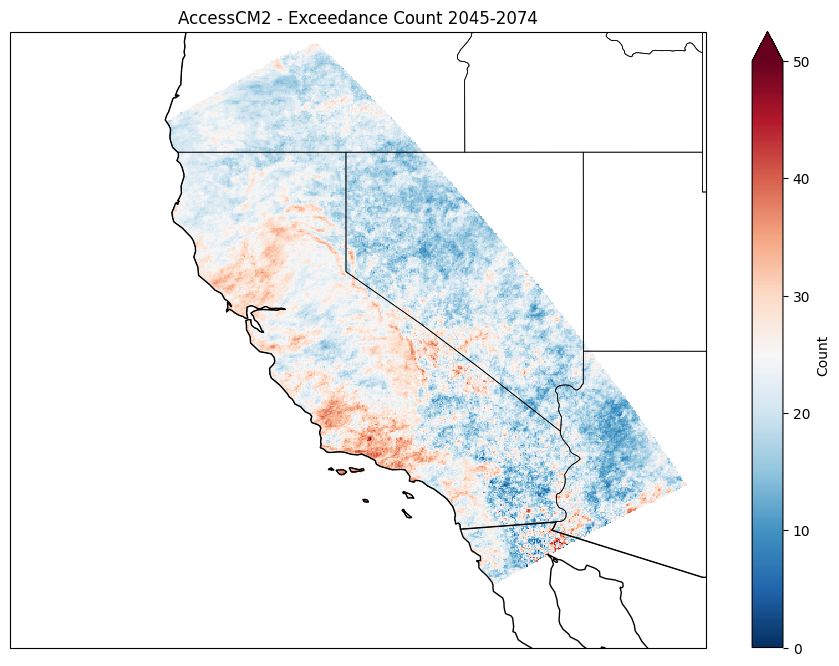

In [101]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_extreme_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Count'})

        plt.title("AccessCM2 - Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "result.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [31]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'total_extreme_precipitation_dask2.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: total_extreme_precipitation_dask2.nc
Results successfully saved to: total_extreme_precipitation_dask2.nc


In [33]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Defaulting to 'pr95' for clarity, overridden in main if needed
    pr_chunks={'time': 'auto'},
    percentile_chunks={}
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        print(f"Opening precipitation file: {pr_file_path} with chunks: {pr_chunks}")
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        print(f"Opening percentile file: {percentile_file_path} with chunks: {percentile_chunks}")
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important to handle the NaNs correctly. This is a lazy Dask operation.
        total_extreme_pr = daily_pr.sum(dim='time', skipna=True)

        # Assign a name and attributes for clarity in output
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        original_pr_units = ds_pr[pr_variable_name].attrs.get('units', 'unknown')
        total_extreme_pr.attrs['description'] = (
            f"Sum of daily precipitation (original units: {original_pr_units}, scaled by 86400) "
            f"on days when daily precipitation exceeded the {percentile_variable_name} "
            f"from {percentile_file_path}."
        )
        # Determine units after scaling (assuming original is kg m-2 s-1 or similar rate)
        if original_pr_units.lower() in ['kg m-2 s-1', 'kg/m2/s']:
            total_extreme_pr.attrs['units'] = 'mm' # Assuming 1 kg m-2 s-1 * 86400 s/day = mm/day
        else:
            total_extreme_pr.attrs['units'] = f"scaled {original_pr_units}"


        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client for monitoring computations.
    # Highly recommended for larger datasets to understand performance.
    # from dask.distributed import Client
    # client = Client() # Creates a local cluster
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # Your code uses 'pr' for the percentile variable name in the main block.
    # The function's default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    precip_chunks_config = {'time': 'auto'} # Chunk along time, let Dask decide size
    # For percentile file, if it's 2D (lat,lon), chunking might be {'lat': 'auto', 'lon': 'auto'}
    # or {} if small enough to be loaded or handled as few chunks.
    percentile_chunks_config = {'lat': 'auto', 'lon': 'auto'} # Or simply {} or {'time': -1} if time dim shouldn't be chunked

    # --- Calculation ---
    print("Starting Dask calculation for extreme precipitation sum...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure

        # --- Optional: Save the result to a new NetCDF file ---
        # The filename from your snippet was 'total_precipitation.nc'.
        # If calculating extreme sum, 'total_extreme_precipitation.nc' might be more descriptive.
        output_filepath = 'total_extreme_precipitation_dask_output2.nc' # Changed for clarity
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # This is where Dask will perform the actual computation and write to disk.
            # For very large outputs, ensure you have disk space.
            # You can specify encoding for compression in to_netcdf for efficiency.
            # e.g., encoding = {total_extreme_pr.name: {"zlib": True, "complevel": 5}}
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client:
    #     client.close()

Starting Dask calculation for extreme precipitation sum...
Opening precipitation file: pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc with chunks: {'time': 'auto'}
Opening percentile file: VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc with chunks: {'lat': 'auto', 'lon': 'auto'}

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:    Total precipitation from days > 95th percentile (Dask)
    description:  Sum of daily precipitation (original units: kg m-2 s-1, sca

In [35]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'total_extreme_precipitation_dask2.nc'
    tot_netcdf_file = 'total_extreme_precipitation_dask_output2.nc'
    output_netcdf_file = 'result2.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_extreme_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_extreme_precipitation

Result successfully saved to: result2.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_extreme_precipitation_scaled' (
                                                                                           lat: 495,
                                                                                           lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_precipit

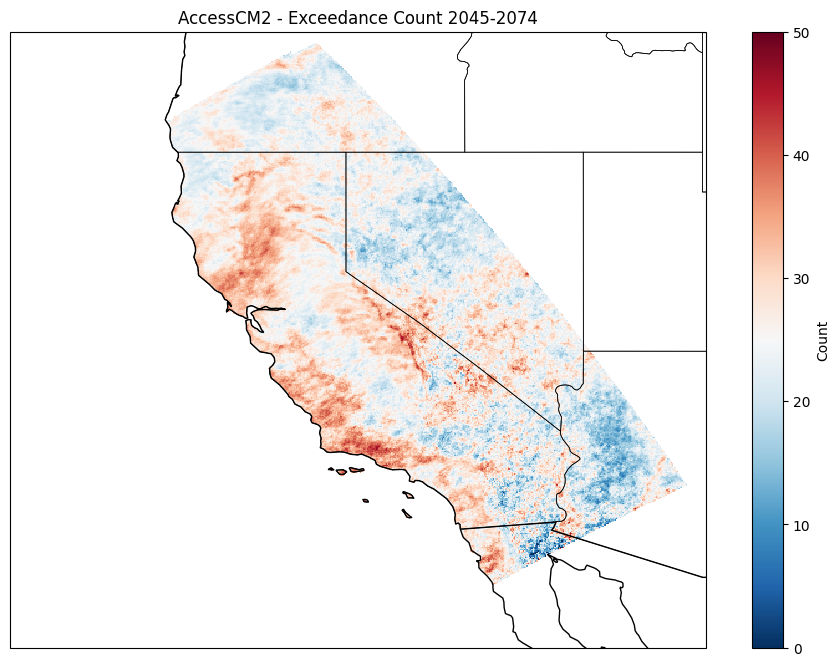

In [99]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_extreme_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=50, cbar_kwargs={'label': 'Count'})

        plt.title("AccessCM2 - Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "result2.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

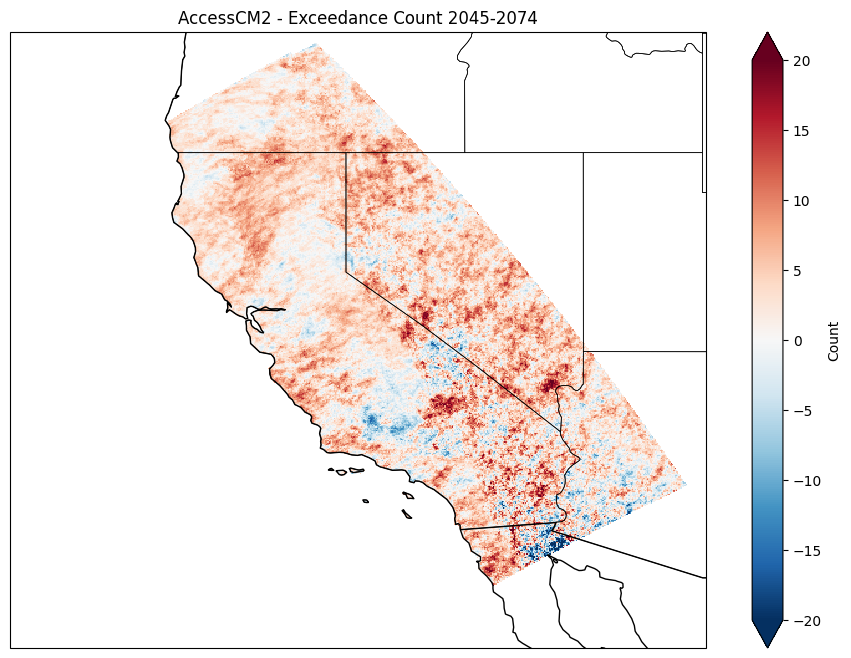

In [95]:
ds1 = xr.open_dataset("result.nc")
ds2 = xr.open_dataset("result2.nc")
data1 = ds1["total_extreme_precipitation_div_by_total_extreme_precipitation_scaled"]
data2 = ds2["total_extreme_precipitation_div_by_total_extreme_precipitation_scaled"]

def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_extreme_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        data = data2-data1

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax = 20,cbar_kwargs={'label': 'Count'})

        plt.title("AccessCM2 - Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "result2.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)